In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import polars as pl
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm

%matplotlib widget

In [2]:
PROJECT_ROOT = Path().cwd().parent
PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"

In [3]:
df = pl.scan_parquet(PROCESSED_DATA_DIR / "LDoGI/shards/shard_3.parquet")
df = df.drop("image")
print(df.head().collect())
c = df.select(pl.len()).collect()["len"][0] # count
c

shape: (5, 3)
┌───────┬───────────┬────────────┐
│ id    ┆ latitude  ┆ longitude  │
│ ---   ┆ ---       ┆ ---        │
│ i64   ┆ f64       ┆ f64        │
╞═══════╪═══════════╪════════════╡
│ 89999 ┆ 42.091598 ┆ -71.265563 │
│ 90000 ┆ 45.588973 ┆ 13.859124  │
│ 90001 ┆ 34.53091  ┆ 69.136749  │
│ 90002 ┆ 35.105    ┆ -85.296166 │
│ 90003 ┆ 44.289386 ┆ -94.45017  │
└───────┴───────────┴────────────┘


30000

In [4]:
TAU_MAX = 50
TAU_MIN = 3

In [5]:
def cell_bounds(cell: str):
    west_long = -180
    east_long = 180
    south_lat = -90
    north_lat = 90

    for divide in cell:
        if int(divide) < 2:
            south_lat = (south_lat + north_lat) / 2
        else:
            north_lat = (south_lat + north_lat) / 2

        if int(divide) % 2 == 0:
            east_long = (west_long + east_long) / 2
        else:
            west_long = (west_long + east_long) / 2

    return south_lat, north_lat, west_long, east_long

In [6]:
s, n, w, e = cell_bounds("1320231103")
sql_s = f"""
select
    count(id)
from
    dataset
where
    latitude >= {s}
    and latitude < {n}
    and longitude >= {w}
    and longitude < {e};
"""

print(sql_s)

# whole: 6615
# top-left: 46
# top-right: 1629
# bottom-left: 38
# bottom-right: 4902



select
    count(id)
from
    dataset
where
    latitude >= 13.7109375
    and latitude < 13.88671875
    and longitude >= 100.1953125
    and longitude < 100.546875;



In [7]:
def is_in_cell(cell: str, lat: float, long: float):
    west_long, east_long, south_lat, north_lat = cell_bounds(cell)
    return west_long <= long <= east_long and south_lat <= lat <= north_lat

In [8]:
print(cell_bounds("0"))
print(cell_bounds("1"))
print(cell_bounds("10"))
print(cell_bounds("11"))
print(cell_bounds("12"))
print(cell_bounds("13"))
print(cell_bounds("121"))

(0.0, 90, -180, 0.0)
(0.0, 90, 0.0, 180)
(45.0, 90, 0.0, 90.0)
(45.0, 90, 90.0, 180)
(0.0, 45.0, 0.0, 90.0)
(0.0, 45.0, 90.0, 180)
(22.5, 45.0, 45.0, 90.0)


In [9]:
print(is_in_cell("10", 054.76098032609564, 10.87077929120943))

False


In [10]:
# create enum of cell states
class CellState:
    STOPPED = 0
    EVALUATING = 1
    ACTIVE = 2

In [11]:
class QuadTree(nx.DiGraph):
    def __init__(self, incoming_graph_data=None, **attr):
        super().__init__(incoming_graph_data, **attr)
        self.add_node("", state=CellState.EVALUATING)

    def expand(self):
        for node_id in list(self.nodes):
            node = self.nodes[node_id]
            if node["state"] == CellState.EVALUATING:
                node["state"] = CellState.STOPPED
                for i in range(4):
                    self.add_node(f"{node_id}{i}", state=CellState.EVALUATING)
                    self.add_edge(node_id, f"{node_id}{i}")

    def evaluate_cells(self, df: pl.LazyFrame, min_count: int, max_count: int):
        for node_id in list(self.nodes):
            node = self.nodes[node_id]
            if not node["state"] == CellState.EVALUATING:
                continue

            west_long, east_long, south_lat, north_lat = cell_bounds(node_id)
            filtered_df = df.filter(
                (pl.col("latitude") < north_lat)
                & (pl.col("latitude") > south_lat)
                & (pl.col("longitude") < east_long)
                & (pl.col("longitude") > west_long)
            )

            count_in_cell = filtered_df.count().collect()["latitude"][0]
            # obj = {
            #     "type": "Polygon",
            #     "coordinates": [
            #         [[west_long, south_lat], [west_long, north_lat], [east_long, north_lat], [east_long, south_lat]]
            #     ],
            # }
            # a = area(obj) / 10**6
            # density = count_in_cell / a
            # print(f"{node_id} density: {density} count: {count_in_cell} area: {a}")
            if count_in_cell > min_count:
                # if count_in_cell == 0 or (density < min_density and a < 100):
                #     print(f"dropped: {node_id} with {count_in_cell} points over {a} km^2")
                #     node["state"] = CellState.STOPPED
                # else:
                #     node["state"] = CellState.ACTIVE
                if count_in_cell < max_count:
                    node["state"] = CellState.ACTIVE
            else:
                node["state"] = CellState.STOPPED

    def is_evaluating(self):
        return CellState.EVALUATING in [node["state"] for node in self.nodes.values()]

Building QuadTree: 0it [00:00, ?it/s]

Building QuadTree: 105it [00:01, 83.36it/s]

QuadTree with 1013 nodes and 1012 edges


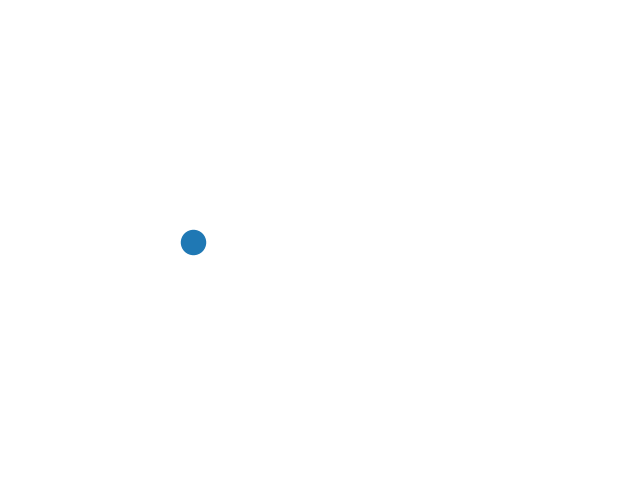

In [12]:
G = QuadTree()
# G.add_node("root", stop=True)
# G.add_nodes_from([(str(i), {"stop": False}) for i in range(4)])
# G.add_edge("root", "0")
# G.add_edge("root", "1")
# G.add_edge("root", "2")
# G.add_edge("root", "3")
subax1 = plt.subplot(121)
subax1.clear()
nx.draw(G, with_labels=True, font_weight='bold')

# subax2 = plt.subplot(122)
# subax2.clear()
t = tqdm(desc="Building QuadTree") # Initialise
while G.is_evaluating():
    G.expand()
    G.evaluate_cells(df, 10, 100)
    t.update(nx.dag_longest_path_length(G))
# nx.draw(G, with_labels=True, font_weight='bold')
t.close()

print(G)
# subax2 = plt.subplot(122)
# subax2.clear()
# nx.draw(G, with_labels=True, font_weight='bold')
# plt.show()

In [12]:
from typing import cast

from networkx import DiGraph

QT = "qt_min50_max2000_df100pct.gml"

G = cast(DiGraph, nx.read_gml(PROCESSED_DATA_DIR / f"LDoGI/quadtrees/{QT}"))

In [13]:
def draw_screen_poly(lats, lons, m, res):
    # Convert to linspace
    lats_linspace = np.linspace(lats[0], lats[1], res)
    lons_linspace = np.linspace(lons[0], lons[1], res)

    # Define the edge points' coordinates
    west_edge_lats = lats_linspace
    west_edge_lons = [lons_linspace[0]] * res
    north_edge_lats = [lats_linspace[-1]] * res
    north_edge_lons = lons_linspace
    east_edge_lats = lats_linspace[::-1]
    east_edge_lons = [lons_linspace[-1]] * res
    south_edge_lats = [lats_linspace[0]] * res
    south_edge_lons = lons_linspace[::-1]

    # Convert to map projection
    geo_rect_lats = np.concatenate(
        [
            west_edge_lats,
            north_edge_lats,
            east_edge_lats,
            south_edge_lats,
        ]
    )
    geo_rect_lons = np.concatenate(
        [
            west_edge_lons,
            north_edge_lons,
            east_edge_lons,
            south_edge_lons,
        ]
    )
    x, y = m(geo_rect_lons, geo_rect_lats)

    xy = zip(x, y)
    # get random color
    colors = ["green", "blue", "red", "yellow", "purple", "orange", "black"]
    facecolor = np.random.choice(colors)

    poly = Polygon(list(xy), facecolor=facecolor, alpha=0.4)
    plt.gca().add_patch(poly)

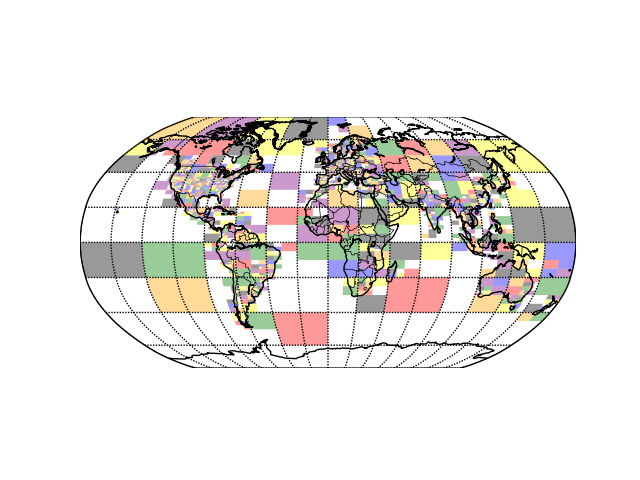

In [44]:
# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.


fig, ax = plt.subplots()  # a figure with a single Axes
m = Basemap(projection="robin", lon_0=0, resolution="c")


# Draw coastlines and countries
m.drawcoastlines()
m.drawcountries()
# m.fillcontinents(color="coral", lake_color="aqua")
# # draw parallels and meridians.
m.drawparallels(np.arange(-90.0, 120.0, 22.5))
m.drawmeridians(np.arange(0.0, 360.0, 22.5))
# m.drawmapboundary(fill_color="aqua")


res = 10
for node, data in [n for n in G.nodes.data() if n[1]["state"] == CellState.ACTIVE]:
    south_lat, north_lat, west_long, east_long = cell_bounds(node)

    draw_screen_poly((south_lat, north_lat), (west_long, east_long), m, res)
plt.savefig('qt_world.png', dpi=300,bbox_inches='tight')

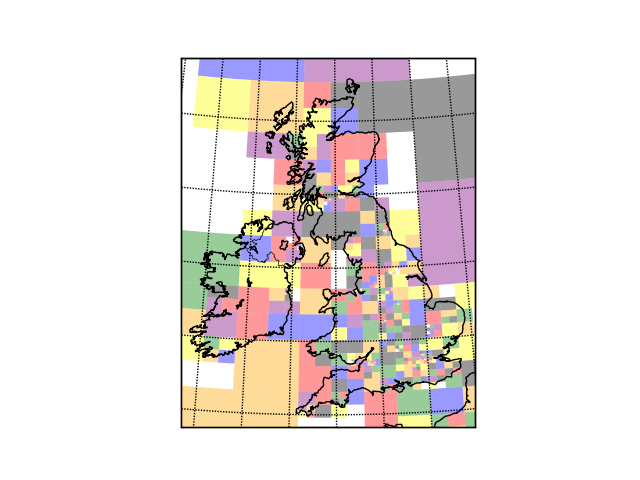

In [16]:
fig, ax = plt.subplots()  # a figure with a single Axes
# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
# are the lat/lon values of the lower left and upper right corners
# of the map.
# resolution = 'i' means use intermediate resolution coastlines.
# lon_0, lat_0 are the central longitude and latitude of the projection.
m = Basemap(llcrnrlon=-10.5,llcrnrlat=49.5,urcrnrlon=3.5,urcrnrlat=59.5,
            resolution='i',projection='tmerc',lon_0=-4.36,lat_0=54.7)
# Draw coastlines and countries
m.drawcoastlines()
m.drawcountries()
# m = Basemap(projection="robin", lon_0=0, resolution="c")
# m.fillcontinents(color="coral", lake_color="aqua")
# # draw parallels and meridians.
m.drawparallels(np.arange(-40,61.,2.))
m.drawmeridians(np.arange(-20.,21.,2.))
m.drawmapboundary(fill_color="white")


res = 10
for node, data in [n for n in G.nodes.data() if n[1]["state"] == CellState.ACTIVE]:
    south_lat, north_lat, west_long, east_long = cell_bounds(node)

    if (south_lat > 59.5 or
        north_lat < 49.5 or
        west_long > 3.5 or
        east_long < -10.5):
        continue

    draw_screen_poly((south_lat, north_lat), (west_long, east_long), m, res)
plt.savefig('qt_england.png', dpi=300,bbox_inches='tight')

In [17]:
def cassini_draw(llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat, save_file, resolution='i', parmer_angle=2):
    fig, ax = plt.subplots()  # a figure with a single Axes
    # llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
    # are the lat/lon values of the lower left and upper right corners
    # of the map.
    # resolution = 'i' means use intermediate resolution coastlines.
    # lon_0, lat_0 are the central longitude and latitude of the projection.


    central_meridian = (llcrnrlon+urcrnrlon)/2
    central_parallel = (llcrnrlat+urcrnrlat)/2
    print(f"central_meridian: {central_meridian}, central_parallel: {central_parallel}")
    m = Basemap(
        llcrnrlon=llcrnrlon,
        llcrnrlat=llcrnrlat,
        urcrnrlon=urcrnrlon,
        urcrnrlat=urcrnrlat,
        resolution=resolution,
        projection="tmerc",
        lon_0=central_meridian,
        lat_0=central_parallel,
    )
    # Draw coastlines and countries
    m.drawcoastlines()
    m.drawcountries()
    # m = Basemap(projection="robin", lon_0=0, resolution="c")
    # m.fillcontinents(color="coral", lake_color="aqua")
    # # draw parallels and meridians.
    m.drawparallels(np.arange(
        ((llcrnrlat//parmer_angle)-1)*parmer_angle, urcrnrlat+1, parmer_angle))
    m.drawmeridians(np.arange(((llcrnrlon//parmer_angle)-1)*parmer_angle, urcrnrlon+1, parmer_angle))
    m.drawmapboundary(fill_color="white")


    res = 10
    for node, data in [n for n in G.nodes.data() if n[1]["state"] == CellState.ACTIVE]:
        south_lat, north_lat, west_long, east_long = cell_bounds(node)

        if (
            south_lat > urcrnrlat+10
            or north_lat < llcrnrlat-10
            or west_long > urcrnrlon+10
            or east_long < llcrnrlon-10
        ):
            continue

        draw_screen_poly((south_lat, north_lat), (west_long, east_long), m, res)
    plt.savefig(save_file, dpi=300, bbox_inches="tight")

central_meridian: -3.5, central_parallel: 54.5


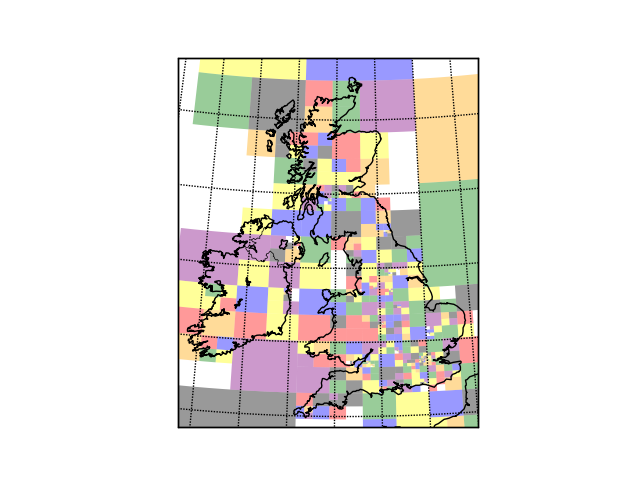

In [19]:
cassini_draw(-10.5,49.5,3.5,59.5, "qt_england.png")

central_meridian: -76.41999999999999, central_parallel: 34.545


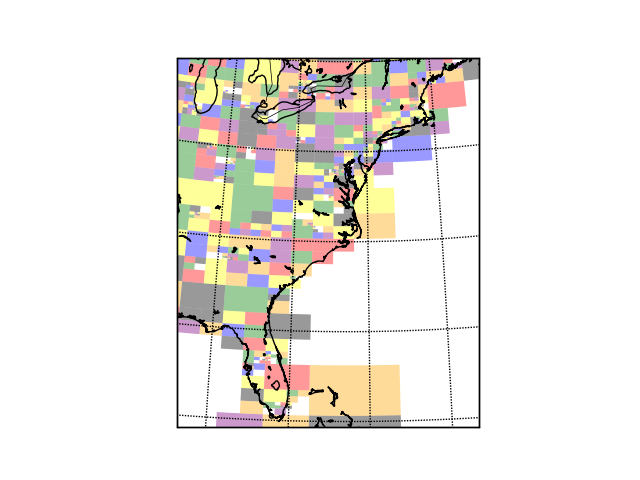

In [20]:
cassini_draw(-86.74,24.33,-66.1,44.76, "qt_useastcoast.png", parmer_angle=5)

central_meridian: 18.0, central_parallel: 44.0


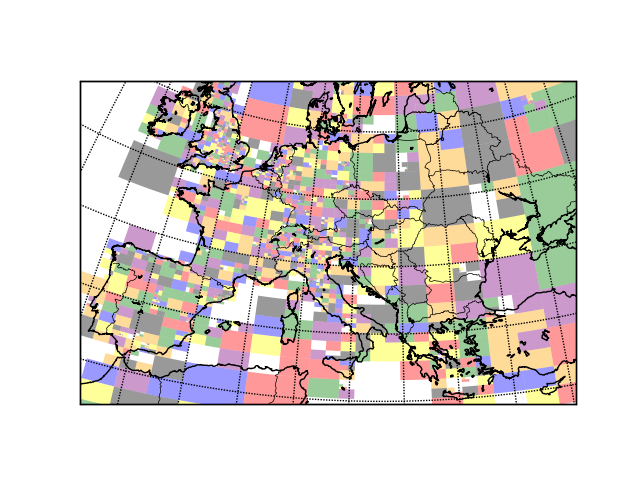

In [21]:
cassini_draw(-8, 32, 44, 56, "qt_europe.png", parmer_angle=5)

central_meridian: 0.31000000000000005, central_parallel: 51.33


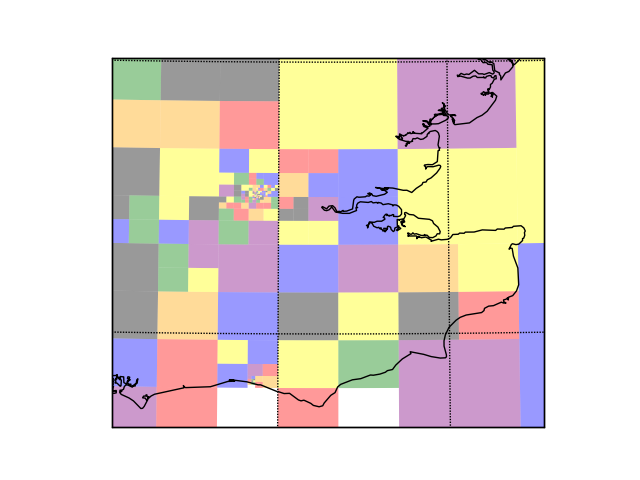

In [22]:
cassini_draw(-0.96, 50.65, 01.58, 52.01, "qt_london.png", parmer_angle=1, resolution="h")